In [9]:
import pandas as pd
import numpy as np
import ternary
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

insitu = pd.read_csv("/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/model/VT16_imputed_plus_syntheticTEST.csv")
satellite = pd.read_excel("/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/Sentinel3_pixel_clean.xlsx")

# fixed parameters
lam0 = 443
a_water_lam0 = 0.0064
bb_water_lam0 = 0.0035

a_cdom_star = 0.426
a_ph_star = 0.024
a_nap_star = 0.105

In [10]:
# clean and prepare in-situ data
insitu = insitu.rename(columns={
    "Prøvetakingstidspunkt": "date",
    "s": "Station"})

insitu["date"] = pd.to_datetime(insitu["date"]).dt.date
insitu = insitu[["date", "SECCI", "CDOM", "KLFA", "TSM", "Station", "is_interpolated"]].dropna()
insitu = insitu.rename(columns={
    "CDOM": "CDOM_insitu",
    "KLFA": "KLFA_insitu",
    "TSM": "TSM_insitu"
})

df_nonint = insitu[insitu["is_interpolated"] == False]
df_int = insitu[insitu["is_interpolated"] == True]

# clean and prepare satellite data
satellite = satellite[["pixel_time", "Name", "iop_agelb_mean", "chl_c2rcc_mean", "spm_nechad_665_mean", "kd489_mean", "iop_apig_mean", "iop_adet_mean"]].dropna()
satellite = satellite.rename(columns={
    "pixel_time": "date",
    "Name": "Station", 
    "iop_agelb_mean": "a_cdom_sat",
    "chl_c2rcc_mean": "KLFA_sat",
    "spm_nechad_665_mean": "TSM_sat",
    "kd489_mean": "kd_sat",
    "iop_apig_mean": "a_ph_sat",
    "iop_adet_mean": "a_nap_sat"
})

satellite["date"] = pd.to_datetime(satellite["date"]).dt.date
satellite = satellite[["date", "kd_sat", "a_cdom_sat", "KLFA_sat", "TSM_sat", "Station", "a_ph_sat", "a_nap_sat"]].dropna()


In [11]:
# IN SITU ////
# noninterpolated data ///
cdom_nonint= df_nonint["CDOM_insitu"].values
chl_nonint = df_nonint["KLFA_insitu"].values
tsm_nonint = df_nonint["TSM_insitu"].values

# k_d from secchi 
# insitu_nonint = df_nonint[["date", "SECCI"]].copy()
# insitu_nonint = insitu_nonint.dropna(subset=["SECCI"])
# df_nonint["k_d_insitu"] = 1.7 / insitu_nonint["SECCI"]

# k_d_array = df_nonint["k_d_insitu"]
# k_d_insitu = df_nonint["k_d_insitu"].mean()

# IOP calculations
a_cdom_nonint= a_cdom_star * cdom_nonint
a_ph_nonint = a_ph_star * chl_nonint
a_nap_nonint = a_nap_star * tsm_nonint

atot_ins = a_water_lam0 + a_cdom_nonint+ a_ph_nonint + a_nap_nonint

# backscatter
alpha = 0.02    # choose within 0.007–0.03 depending on your water type
beta  = 0.9     # usually between 0.7 and 1.1
bb_p = alpha * (tsm_nonint ** beta)

bb_nonint = bb_p + bb_water_lam0 

# interpolated data ///
cdom_int= df_int["CDOM_insitu"].values
chl_int = df_int["KLFA_insitu"].values
tsm_int = df_int["TSM_insitu"].values

# k_d from secchi 
# insitu_int = df_int[["date", "SECCI"]].copy()
# insitu_int = insitu_int.dropna(subset=["SECCI"])
# df_int["k_d_insitu"] = 1.7 / insitu_int["SECCI"]
# 
# k_d_array = df_int["k_d_insitu"]
# k_d_insitu = df_int["k_d_insitu"].mean()

# IOP calculations
a_cdom_int= a_cdom_star * cdom_int
a_ph_int = a_ph_star * chl_int
a_nap_int = a_nap_star * tsm_int

atot_ins = a_water_lam0 + a_cdom_int+ a_ph_int + a_nap_int

# # backscatter
# alpha = 0.02    # choose within 0.007–0.03 depending on your water type
# beta  = 0.9     # usually between 0.7 and 1.1
# bb_p = alpha * (tsm_int ** beta)

# bb_int = bb_p + bb_water_lam0 

# SATELLITE ////
cdom_sat = satellite["a_cdom_sat"].values
chl_sat = satellite["KLFA_sat"].values
tsm_sat = satellite["TSM_sat"].values

# IOP calculations
a_cdom_sat = cdom_sat
a_ph_sat = a_ph_star * chl_sat
a_nap_sat = a_nap_star * tsm_sat

a_cdom_sat_1 = a_cdom_sat
a_ph_sat_1 = satellite["a_ph_sat"].values
a_nap_sat_1 = satellite["a_nap_sat"].values

atot_sat = a_water_lam0 + a_cdom_sat + a_ph_sat + a_nap_sat
atot_sat_1 = a_water_lam0 + a_cdom_sat_1 + a_ph_sat_1 + a_nap_sat_1

# # backscatter
# alpha = 0.02    # choose within 0.007–0.03 depending on your water type
# beta  = 0.9     # usually between 0.7 and 1.1
# bb_p_s = alpha * (tsm_sat ** beta)

# bb_sat = bb_p_s + bb_water_lam0 

In [12]:
# Absorption Fractions for insitu
# noninterpolated data ///
atot_nonint_oac = a_cdom_nonint + a_ph_nonint + a_nap_nonint

f_cdom_nonint = a_cdom_nonint/ atot_nonint_oac
f_ph_nonint   = a_ph_nonint   / atot_nonint_oac
f_nap_nonint  = a_nap_nonint  / atot_nonint_oac

# interpolated data ///
atot_int_oac = a_cdom_int + a_ph_int + a_nap_int

f_cdom_int = a_cdom_int / atot_int_oac
f_ph_int   = a_ph_int   / atot_int_oac
f_nap_int  = a_nap_int  / atot_int_oac

# Absorption Fractions for satellite
atot_sat_oac = a_cdom_sat + a_ph_sat + a_nap_sat

f_cdom_sat = a_cdom_sat / atot_sat_oac
f_ph_sat   = a_ph_sat   / atot_sat_oac
f_nap_sat  = a_nap_sat  / atot_sat_oac

# Absorption Fractions for satellite 1
atot_sat_oac_1 = a_cdom_sat_1 + a_ph_sat_1 + a_nap_sat_1

f_cdom_sat_1 = a_cdom_sat_1 / atot_sat_oac_1
f_ph_sat_1   = a_ph_sat_1   / atot_sat_oac_1
f_nap_sat_1  = a_nap_sat_1  / atot_sat_oac_1

/opt/miniconda3/envs/sentinel3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


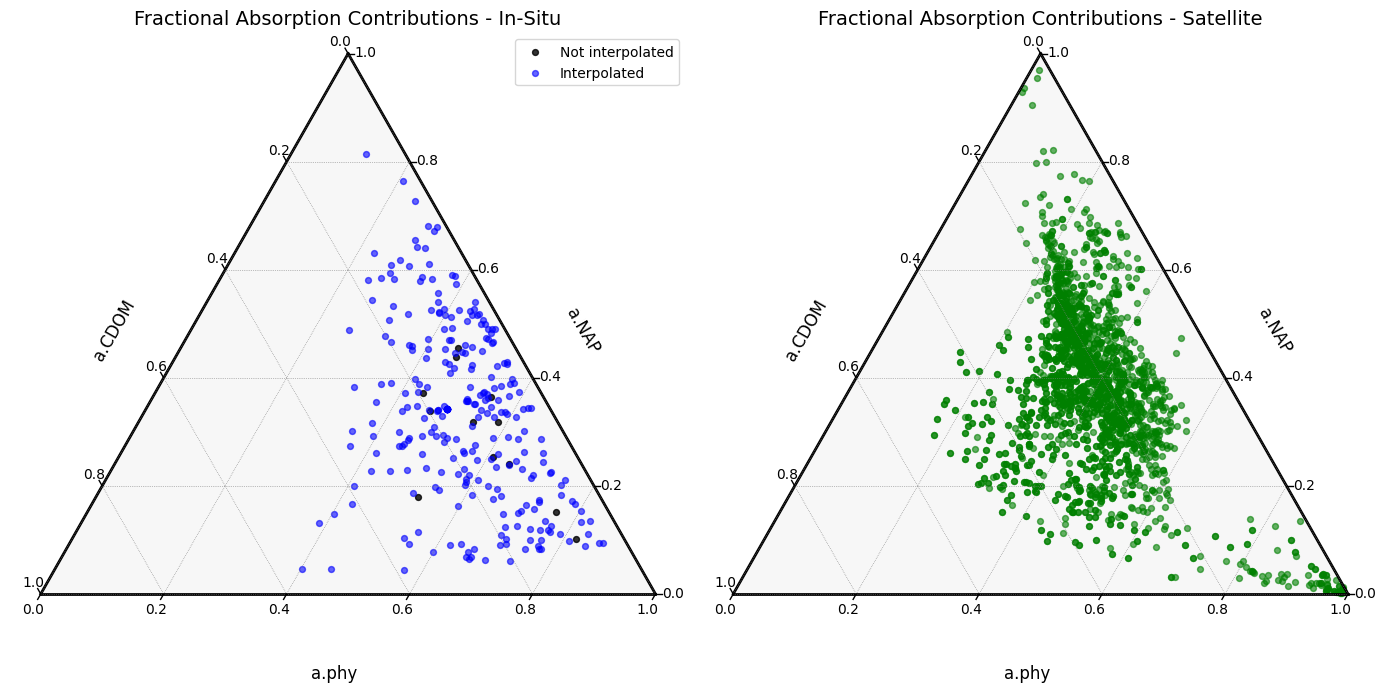

In [13]:
scale = 1.0  # fractions sum to 1

# Prepare points
points_nonint = list(zip(f_cdom_nonint, f_nap_nonint, f_ph_nonint))
points_int    = list(zip(f_cdom_int, f_nap_int, f_ph_int))
points_sat    = list(zip(f_cdom_sat, f_nap_sat, f_ph_sat))

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---------------- IN-SITU (right subplot) ----------------
ax = axes[0]
ax.axis("off")

tax_ins = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax_ins.boundary(linewidth=2.0)
tax_ins.gridlines(color="gray", multiple=0.2, linewidth=0.5)
tax_ins.set_title("Fractional Absorption Contributions - In-Situ", fontsize=14)
tax_ins.left_axis_label("a.CDOM", offset=0.14, fontsize=12)
tax_ins.right_axis_label("a.NAP", offset=0.14, fontsize=12)
tax_ins.bottom_axis_label("a.phy", offset=0.08, fontsize=12)
tax_ins.ticks(axis='lbr', multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)

# Plot non-interpolated vs interpolated
tax_ins.scatter(points_nonint, s=18, color="black", alpha=0.8, label="Not interpolated")
tax_ins.scatter(points_int, s=18, color="blue", alpha=0.6, label="Interpolated")

tax_ins.legend()
tax_ins.clear_matplotlib_ticks()
tax_ins._redraw_labels()

# ---------------- SATELLITE (left subplot) ----------------
ax = axes[1]
ax.axis("off")

tax_sat = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax_sat.boundary(linewidth=2.0)
tax_sat.gridlines(color="gray", multiple=0.2, linewidth=0.5)
tax_sat.set_title("Fractional Absorption Contributions - Satellite", fontsize=14)
tax_sat.left_axis_label("a.CDOM", offset=0.14, fontsize=12)
tax_sat.right_axis_label("a.NAP", offset=0.14, fontsize=12)
tax_sat.bottom_axis_label("a.phy", offset=0.08, fontsize=12)
tax_sat.ticks(axis='lbr', multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)

# Plot satellite points
tax_sat.scatter(points_sat, s=18, color="green", alpha=0.6)

tax_sat.clear_matplotlib_ticks()
tax_sat._redraw_labels()

plt.tight_layout()
plt.show()

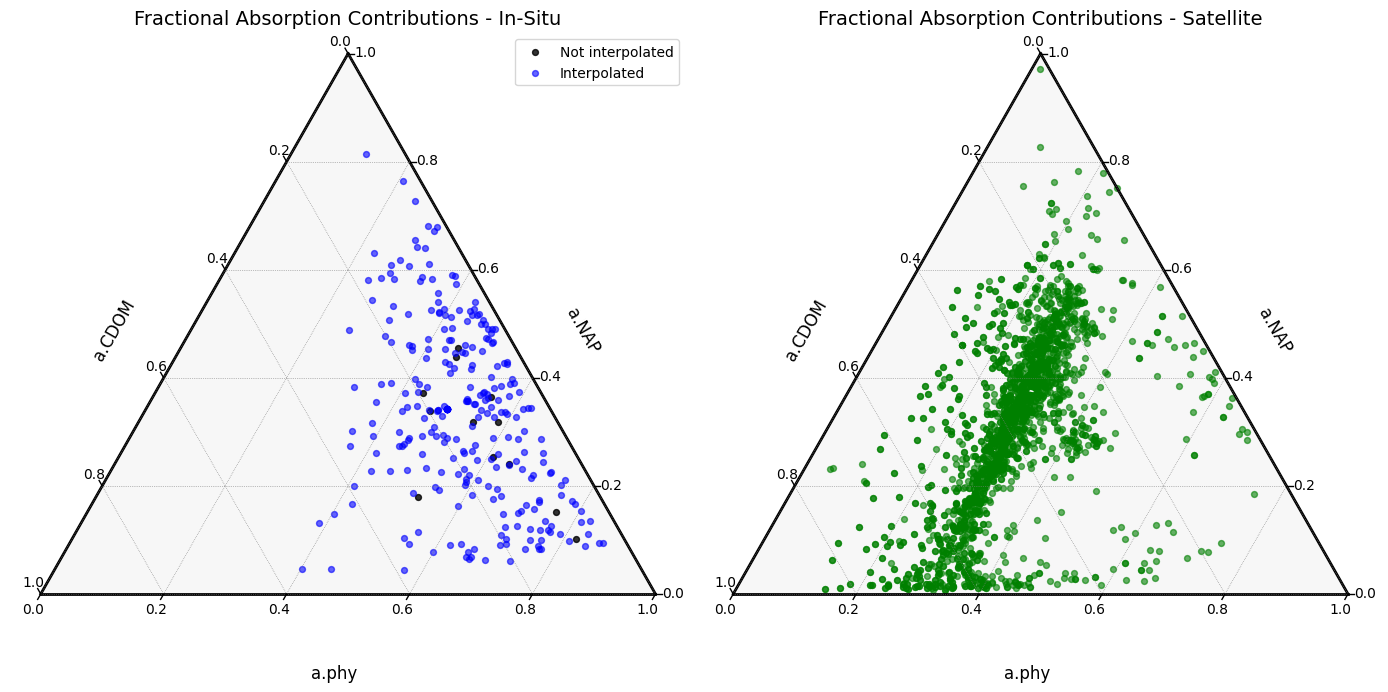

In [14]:
scale = 1.0  # fractions sum to 1

# Absorption Fractions for satellite

atot_sat_oac_1 = a_cdom_sat_1 + a_ph_sat_1 + a_nap_sat_1

f_cdom_sat_1 = a_cdom_sat_1 / atot_sat_oac_1
f_ph_sat_1   = a_ph_sat_1   / atot_sat_oac_1
f_nap_sat_1  = a_nap_sat_1  / atot_sat_oac_1

# Prepare points
points_nonint = list(zip(f_cdom_nonint, f_nap_nonint, f_ph_nonint))
points_int    = list(zip(f_cdom_int, f_nap_int, f_ph_int))
points_sat_1    = list(zip(f_cdom_sat_1, f_nap_sat_1, f_ph_sat_1))

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---------------- IN-SITU (right subplot) ----------------
ax = axes[0]
ax.axis("off")

tax_ins = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax_ins.boundary(linewidth=2.0)
tax_ins.gridlines(color="gray", multiple=0.2, linewidth=0.5)
tax_ins.set_title("Fractional Absorption Contributions - In-Situ", fontsize=14)
tax_ins.left_axis_label("a.CDOM", offset=0.14, fontsize=12)
tax_ins.right_axis_label("a.NAP", offset=0.14, fontsize=12)
tax_ins.bottom_axis_label("a.phy", offset=0.08, fontsize=12)
tax_ins.ticks(axis='lbr', multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)

# Plot non-interpolated vs interpolated
tax_ins.scatter(points_nonint, s=18, color="black", alpha=0.8, label="Not interpolated")
tax_ins.scatter(points_int, s=18, color="blue", alpha=0.6, label="Interpolated")

tax_ins.legend()
tax_ins.clear_matplotlib_ticks()
tax_ins._redraw_labels()

# ---------------- SATELLITE (left subplot) ----------------
ax = axes[1]
ax.axis("off")

tax_sat = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
tax_sat.boundary(linewidth=2.0)
tax_sat.gridlines(color="gray", multiple=0.2, linewidth=0.5)
tax_sat.set_title("Fractional Absorption Contributions - Satellite", fontsize=14)
tax_sat.left_axis_label("a.CDOM", offset=0.14, fontsize=12)
tax_sat.right_axis_label("a.NAP", offset=0.14, fontsize=12)
tax_sat.bottom_axis_label("a.phy", offset=0.08, fontsize=12)
tax_sat.ticks(axis='lbr', multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)

# Plot satellite points
tax_sat.scatter(points_sat_1, s=18, color="green", alpha=0.6)

tax_sat.clear_matplotlib_ticks()
tax_sat._redraw_labels()

plt.tight_layout()
plt.show()


/opt/miniconda3/envs/sentinel3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


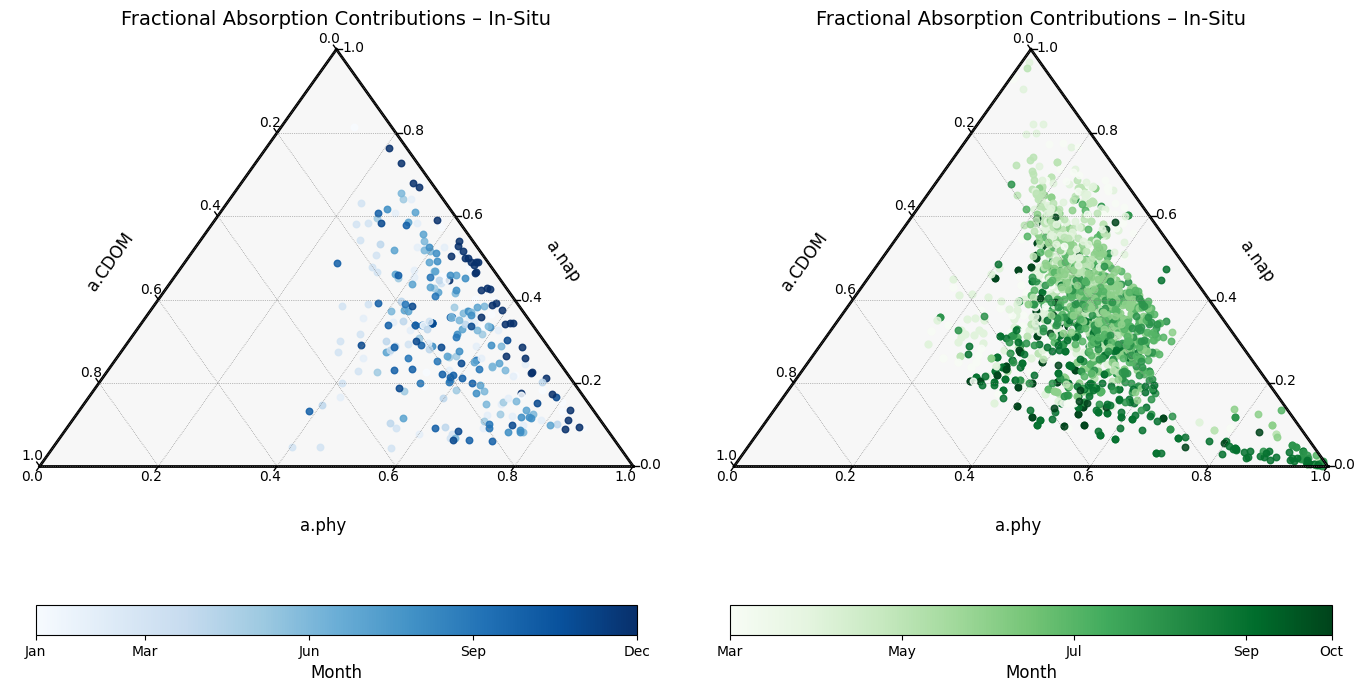

In [15]:
scale = 1.0

def plot_ternary_insitu_vs_satellite(
    f_cdom_ins, f_ph_ins, f_nap_ins, times_ins,
    f_cdom_sat, f_ph_sat, f_nap_sat, times_sat,
    cmap_ins='Blues', cmap_sat='Greens'
):

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # --- In-situ (right subplot) ---
    ax = axes[0]
    ax.axis("off")
    tax_ins = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax_ins.boundary(linewidth=2.0)
    tax_ins.gridlines(color="gray", multiple=0.2, linewidth=0.5)
    tax_ins.set_title("Fractional Absorption Contributions – In-Situ", fontsize=14)
    tax_ins.left_axis_label("a.CDOM", fontsize=12, offset=0.14)
    tax_ins.right_axis_label("a.nap", fontsize=12, offset=0.14)
    tax_ins.bottom_axis_label("a.phy", fontsize=12, offset=0.08)

    months_ins = np.array([t.month for t in times_ins])
    norm_ins = mcolors.Normalize(vmin=1, vmax=12)
    colors_ins = [plt.get_cmap(cmap_ins)(norm_ins(m)) for m in months_ins]

    points_ins = list(zip(f_cdom_ins, f_nap_ins, f_ph_ins))
    for p, col in zip(points_ins, colors_ins):
        tax_ins.scatter([p], s=22, color=col, alpha=0.85)

    tax_ins.ticks(axis="lbr", multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)
    tax_ins.clear_matplotlib_ticks()
    tax_ins._redraw_labels()

    sm_ins = cm.ScalarMappable(cmap=cmap_ins, norm=norm_ins)
    sm_ins.set_array([])
    cbar_ins = plt.colorbar(sm_ins, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    cbar_ins.set_label("Month", fontsize=12)
    cbar_ins.set_ticks([1, 3, 6, 9, 12])
    cbar_ins.set_ticklabels(["Jan","Mar","Jun","Sep","Dec"])

    # --- Satellite (left subplot) ---
    ax = axes[1]
    ax.axis("off")
    tax_sat = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax_sat.boundary(linewidth=2.0)
    tax_sat.gridlines(color="gray", multiple=0.2, linewidth=0.5)
    tax_sat.set_title("Fractional Absorption Contributions – In-Situ", fontsize=14)
    tax_sat.left_axis_label("a.CDOM", fontsize=12, offset=0.14)
    tax_sat.right_axis_label("a.nap", fontsize=12, offset=0.14)
    tax_sat.bottom_axis_label("a.phy", fontsize=12, offset=0.08)

    months_sat = np.array([t.month for t in times_sat])
    norm_sat = mcolors.Normalize(vmin=3, vmax=10)
    colors_sat = [plt.get_cmap(cmap_sat)(norm_sat(m)) for m in months_sat]

    points_sat = list(zip(f_cdom_sat, f_nap_sat, f_ph_sat))
    for p, col in zip(points_sat, colors_sat):
        tax_sat.scatter([p], s=22, color=col, alpha=0.85)

    tax_sat.ticks(axis="lbr", multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)
    tax_sat.clear_matplotlib_ticks()
    tax_sat._redraw_labels()

    sm_sat = cm.ScalarMappable(cmap=cmap_sat, norm=norm_sat)
    sm_sat.set_array([])
    cbar_sat = plt.colorbar(sm_sat, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    cbar_sat.set_label("Month", fontsize=12)
    cbar_sat.set_ticks([3, 5, 7, 9, 10])
    cbar_sat.set_ticklabels(["Mar","May","Jul","Sep","Oct"])

    plt.tight_layout()
    plt.show()

# in-situ application
f_cdom_ins = np.concatenate([f_cdom_nonint, f_cdom_int])
f_ph_ins   = np.concatenate([f_ph_nonint, f_ph_int])
f_nap_ins  = np.concatenate([f_nap_nonint, f_nap_int])

plot_ternary_insitu_vs_satellite(
    f_cdom_ins=f_cdom_ins, f_ph_ins=f_ph_ins, f_nap_ins=f_nap_ins, times_ins=insitu["date"],
    f_cdom_sat=f_cdom_sat, f_ph_sat=f_ph_sat, f_nap_sat=f_nap_sat, times_sat=satellite["date"],
    cmap_ins='Blues',
    cmap_sat='Greens'
)

/opt/miniconda3/envs/sentinel3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/opt/miniconda3/envs/sentinel3/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


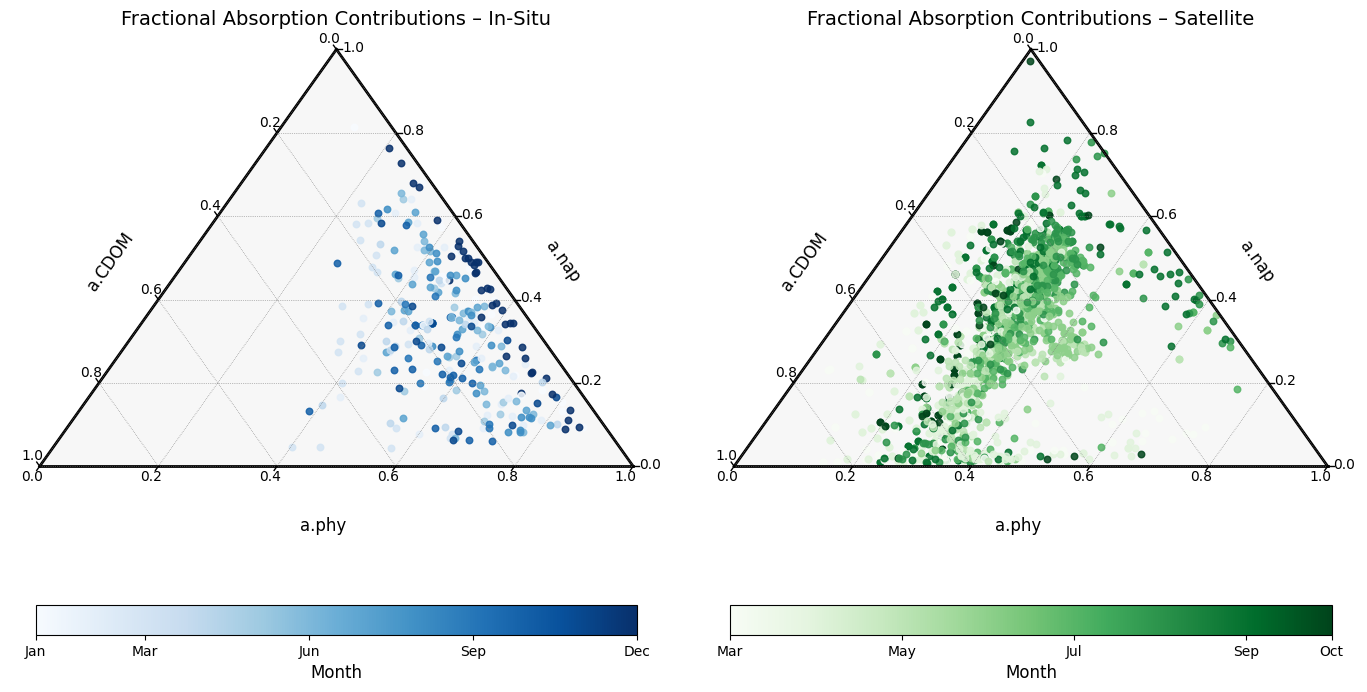

In [16]:
scale = 1.0

def plot_ternary_insitu_vs_satellite(
    f_cdom_ins, f_ph_ins, f_nap_ins, times_ins,
    f_cdom_sat_1, f_ph_sat_1, f_nap_sat_1, times_sat,
    cmap_ins='Blues', cmap_sat='Greens'
):

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # --- In-situ (right subplot) ---
    ax = axes[0]
    ax.axis("off")
    tax_ins = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax_ins.boundary(linewidth=2.0)
    tax_ins.gridlines(color="gray", multiple=0.2, linewidth=0.5)
    tax_ins.set_title("Fractional Absorption Contributions – In-Situ", fontsize=14)
    tax_ins.left_axis_label("a.CDOM", fontsize=12, offset=0.14)
    tax_ins.right_axis_label("a.nap", fontsize=12, offset=0.14)
    tax_ins.bottom_axis_label("a.phy", fontsize=12, offset=0.08)

    months_ins = np.array([t.month for t in times_ins])
    norm_ins = mcolors.Normalize(vmin=1, vmax=12)
    colors_ins = [plt.get_cmap(cmap_ins)(norm_ins(m)) for m in months_ins]

    points_ins = list(zip(f_cdom_ins, f_nap_ins, f_ph_ins))
    for p, col in zip(points_ins, colors_ins):
        tax_ins.scatter([p], s=22, color=col, alpha=0.85)

    tax_ins.ticks(axis="lbr", multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)
    tax_ins.clear_matplotlib_ticks()
    tax_ins._redraw_labels()

    sm_ins = cm.ScalarMappable(cmap=cmap_ins, norm=norm_ins)
    sm_ins.set_array([])
    cbar_ins = plt.colorbar(sm_ins, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    cbar_ins.set_label("Month", fontsize=12)
    cbar_ins.set_ticks([1, 3, 6, 9, 12])
    cbar_ins.set_ticklabels(["Jan","Mar","Jun","Sep","Dec"])

    # --- Satellite (left subplot) ---
    ax = axes[1]
    ax.axis("off")
    tax_sat = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax_sat.boundary(linewidth=2.0)
    tax_sat.gridlines(color="gray", multiple=0.2, linewidth=0.5)
    tax_sat.set_title("Fractional Absorption Contributions – Satellite", fontsize=14)
    tax_sat.left_axis_label("a.CDOM", fontsize=12, offset=0.14)
    tax_sat.right_axis_label("a.nap", fontsize=12, offset=0.14)
    tax_sat.bottom_axis_label("a.phy", fontsize=12, offset=0.08)

    months_sat = np.array([t.month for t in times_sat])
    norm_sat = mcolors.Normalize(vmin=3, vmax=10)
    colors_sat = [plt.get_cmap(cmap_sat)(norm_sat(m)) for m in months_sat]

    points_sat = list(zip(f_cdom_sat_1, f_nap_sat_1, f_ph_sat_1))
    for p, col in zip(points_sat, colors_sat):
        tax_sat.scatter([p], s=22, color=col, alpha=0.85)

    tax_sat.ticks(axis="lbr", multiple=0.2, tick_formats="%.1f", fontsize=10, linewidth=1)
    tax_sat.clear_matplotlib_ticks()
    tax_sat._redraw_labels()

    sm_sat = cm.ScalarMappable(cmap=cmap_sat, norm=norm_sat)
    sm_sat.set_array([])
    cbar_sat = plt.colorbar(sm_sat, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
    cbar_sat.set_label("Month", fontsize=12)
    cbar_sat.set_ticks([3, 5, 7, 9, 10])
    cbar_sat.set_ticklabels(["Mar","May","Jul","Sep","Oct"])

    plt.tight_layout()
    plt.show()

# in-situ application
f_cdom_ins = np.concatenate([f_cdom_nonint, f_cdom_int])
f_ph_ins   = np.concatenate([f_ph_nonint, f_ph_int])
f_nap_ins  = np.concatenate([f_nap_nonint, f_nap_int])

plot_ternary_insitu_vs_satellite(
    f_cdom_ins=f_cdom_ins, f_ph_ins=f_ph_ins, f_nap_ins=f_nap_ins, times_ins=insitu["date"],
    f_cdom_sat_1=f_cdom_sat_1, f_ph_sat_1=f_ph_sat_1, f_nap_sat_1=f_nap_sat_1, times_sat=satellite["date"],
    cmap_ins='Blues',
    cmap_sat='Greens'
)